# Energy Forcasting - Time Series Analysis Using XGBoost

### Objective

Load forcasting is a critical problem in the energy sector. It is a technique used by electricity companies to predict the power needed for the demand and supply. It allows for better planning and management of resources and not only helps in reducing the cost of electricity but also helps in reducing the carbon footprint by reducing the wastage of energy. (Journal Article: https://www.mdpi.com/2071-1050/15/9/7087)

In this notebook, we will approach this problem using a regression analysis using XGBoost to forecast the general energy load. 

Load forecasting is concerned with the prediction of hourly, daily, weekly and monthly values of load and of the peak load.

### Dataset
Refer to README.md for more information on the dataset.

### Limitations

Unfortunately, the availible data does not separate the data into different energy sources, so we will be using the general energy load as a whole. Whereas in reality, the energy load is made up of different sources such as coal, nuclear, hydro, wind, solar which all are effected differently by each feature. For example, solar energy is dependent on the time of day and weather, whereas nuclear energy is not. 

Model Limitations: 

With XGBoost, we are limited by only being able to predict the future based within the range of historic values. This means that we are not able to predict any future events that may effect the energy load


### Features 

The most commonly come from seasonal data (time of day, holidays), historical data (past electricity loads), weather data (temperature), and human mobility data (tourism, work).

## Imports and Setup

In [22]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import xgboost as xgb
from sklearn.metrics import mean_squared_error

from datetime import datetime

from utils.clean_data import mean_std_outliers, missing_data
from utils.preprocess import create_timeseries_features, create_cat_features
from utils.plot import plot_train_test_split, plot_mean_monthly, plot_time_range, plot_feature_importance

colour_pal = sns.color_palette('flare')

In [23]:
TARGET_CUTOFF_DATE = '01-01-2016'

### Load Dataset & Convert Date Column 


In [24]:
df = pd.read_csv(
    './DataSet/Regions/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [25]:
df.tail(20)

,PJME_MW
Datetime,
2018-01-01 05:00:00,38049.0
2018-01-01 06:00:00,38821.0
2018-01-01 07:00:00,39762.0
2018-01-01 08:00:00,40154.0
2018-01-01 09:00:00,40309.0
2018-01-01 10:00:00,39884.0
2018-01-01 11:00:00,39544.0
2018-01-01 12:00:00,39270.0
2018-01-01 13:00:00,38987.0


Check for missing values

In [26]:
missing_data(df)

,Total,Percent,Types
PJME_MW,0,0.0,float64


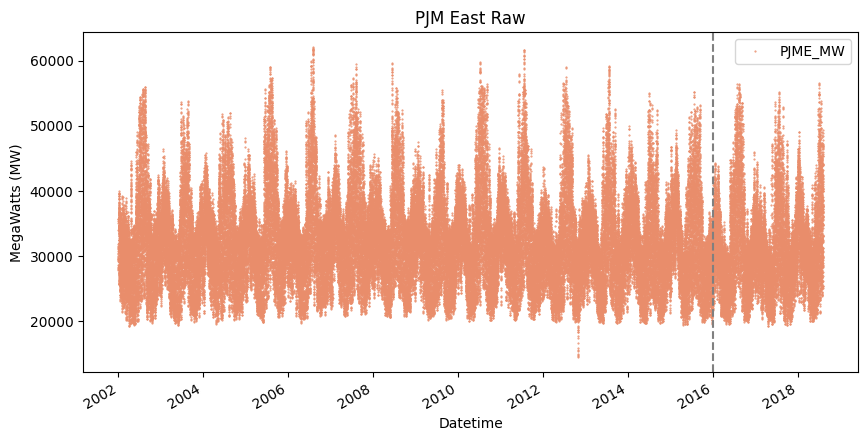

In [27]:
df.plot(style='.', figsize=(10, 5), ms=1, color=colour_pal,
          ylabel='MegaWatts (MW)', title='PJM East Raw')
plt.axvline(TARGET_CUTOFF_DATE,color='grey',linestyle='--')
plt.show()

## Data Preprocessing

In [28]:
df.describe()

,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


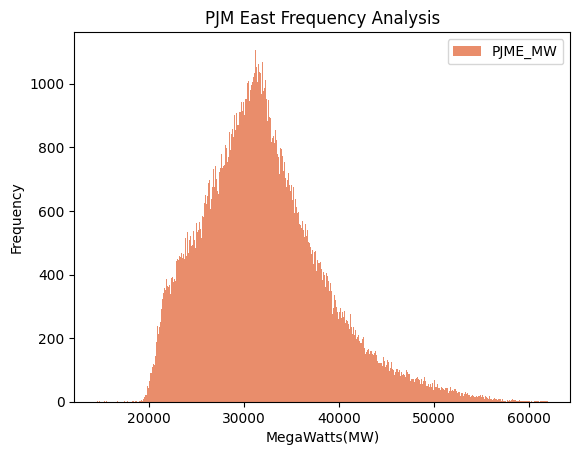

In [29]:
df.plot(kind='hist', bins=500, color=colour_pal,
          xlabel='MegaWatts(MW)', title='PJM East Frequency Analysis')
plt.show()

In [30]:
upper_threshold, lower_threshold = mean_std_outliers(df)
print(lower_threshold.max(), upper_threshold.min())

Outlier threshold calculations: Lower threshold:                     PJME_MW
Datetime                    
2012-10-31 02:00:00  18618.0
2012-10-31 03:00:00  18350.0
2012-10-31 04:00:00  18330.0
2012-10-31 05:00:00  18880.0
2012-10-30 01:00:00  15390.0
2012-10-30 02:00:00  14955.0
2012-10-30 03:00:00  14586.0
2012-10-30 04:00:00  14544.0
2012-10-30 05:00:00  14821.0
2012-10-30 06:00:00  15526.0
2012-10-30 07:00:00  16688.0
2012-10-30 08:00:00  17734.0
2012-10-30 09:00:00  18675.0
2012-10-29 22:00:00  19085.0
2012-10-29 23:00:00  17422.0
2012-10-30 00:00:00  15919.0 Upper threshold:                      PJME_MW
Datetime                    
2002-08-19 14:00:00  52145.0
2002-08-19 15:00:00  53094.0
2002-08-19 16:00:00  53575.0
2002-08-19 17:00:00  53739.0
2002-08-19 18:00:00  53202.0
...                      ...
2018-07-01 18:00:00  51803.0
2018-06-18 16:00:00  51818.0
2018-06-18 17:00:00  52558.0
2018-06-18 18:00:00  52213.0
2018-06-18 19:00:00  51597.0

[1318 rows x 1 columns]
PJME_MW    

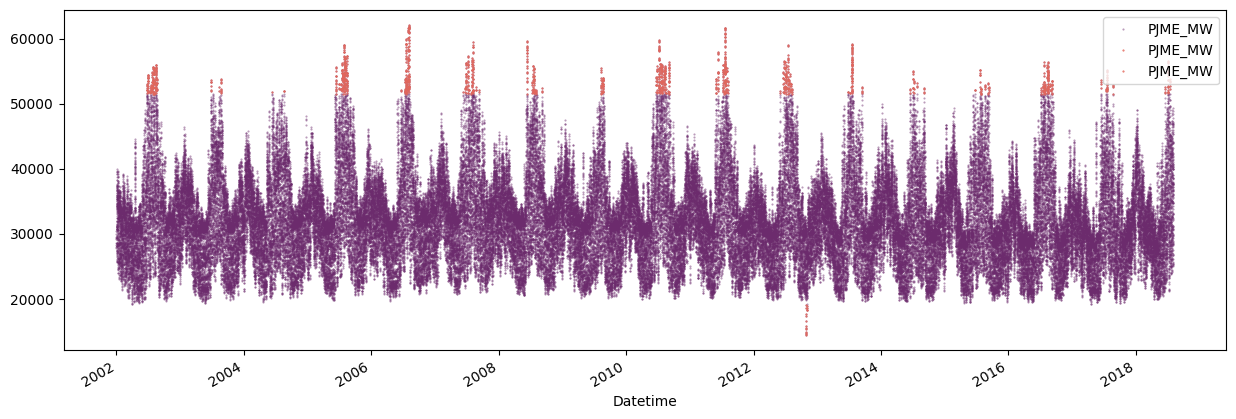

In [31]:
fig, ax = plt.subplots(figsize=(15, 5))
df.plot(style='.', ms=1, color=colour_pal[5], alpha=0.5, ax=ax)
upper_threshold.plot(style='.', ax=ax, ms=1, color=colour_pal[1])
lower_threshold.plot(style='.', ax=ax, ms=1, color=colour_pal[1])
plt.show()

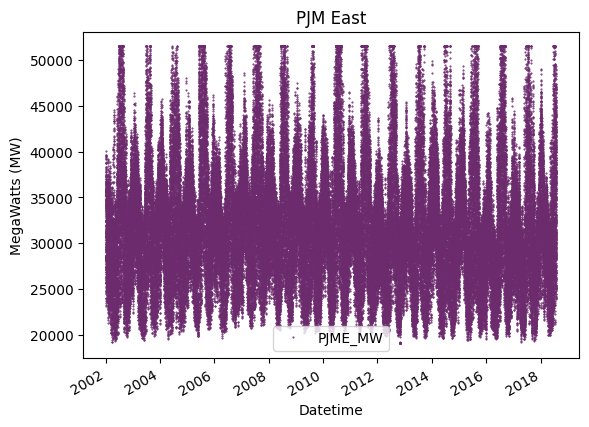

<Figure size 640x480 with 0 Axes>

In [32]:
df['PJME_MW'] = df['PJME_MW'].clip(upper=51472, lower=19085).copy()
df.plot(style='.', ms=1, color=colour_pal[5],
          ylabel='MegaWatts (MW)', title='PJM East')
plt.show()
plt.clf()

## Seasonal Decomposition

 Retrieve the trends, seasonal and residual components of the time series data

 (Using statsmodels seasonal_decompose)

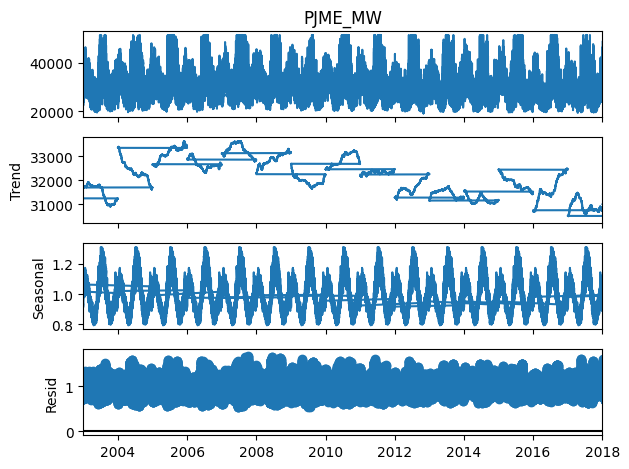

In [33]:
ANNUAL_PERIODS = 365*24
decomp = seasonal_decompose(
    df['PJME_MW'], model='multiplicative',extrapolate_trend='freq',  period=ANNUAL_PERIODS)
decomp.plot()

plt.show()

## Feature Engineering

In [34]:
df_features = create_timeseries_features(df)



In [35]:
df_features.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1


### USA Holidays

In [36]:
cal = calendar()
holidays = cal.holidays(start=df.index.min(),
                        end=df.index.max(),
                        return_name=True)
holiday_df = pd.DataFrame(data=holidays,
                          columns=['holiday'])
holiday_df = holiday_df.reset_index().rename(columns={'index': 'ds'})
holiday_df

,ds,holiday
0,2002-01-21,"Birthday of Martin Luther King, Jr."
1,2002-02-18,Washington's Birthday
2,2002-05-27,Memorial Day
3,2002-07-04,Independence Day
4,2002-09-02,Labor Day
...,...,...
159,2018-01-01,New Year's Day
160,2018-01-15,"Birthday of Martin Luther King, Jr."
161,2018-02-19,Washington's Birthday
162,2018-05-28,Memorial Day


## EDA

### Energy Load Data By Hour

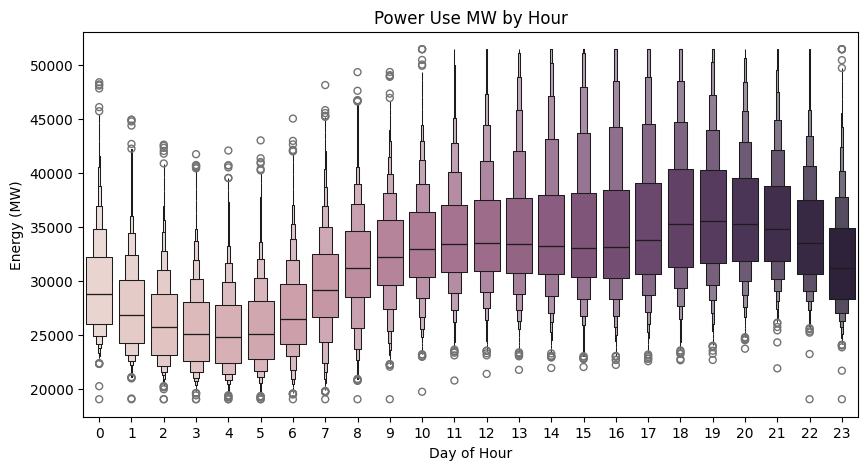

In [37]:
plot_time_range(df_features, 'hour')

### Energy Load Data Per Weekday

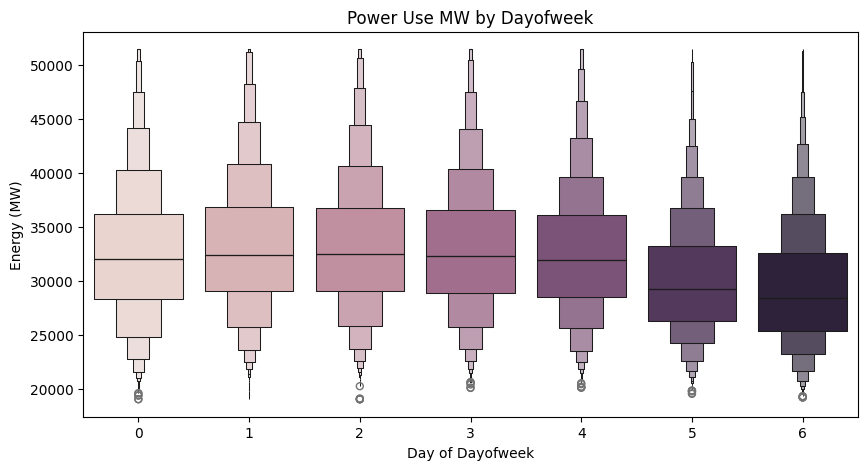

In [38]:
plot_time_range(df_features, 'dayofweek')

### Energy Load Data By Month

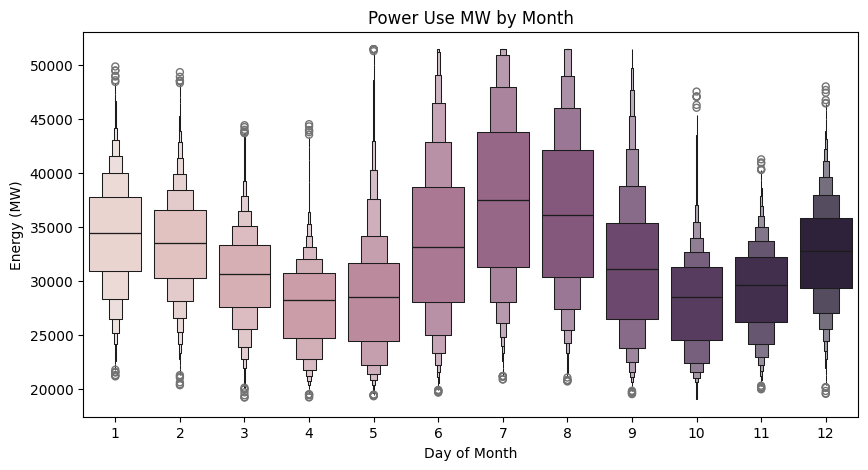

In [39]:
plot_time_range(df_features, 'month')

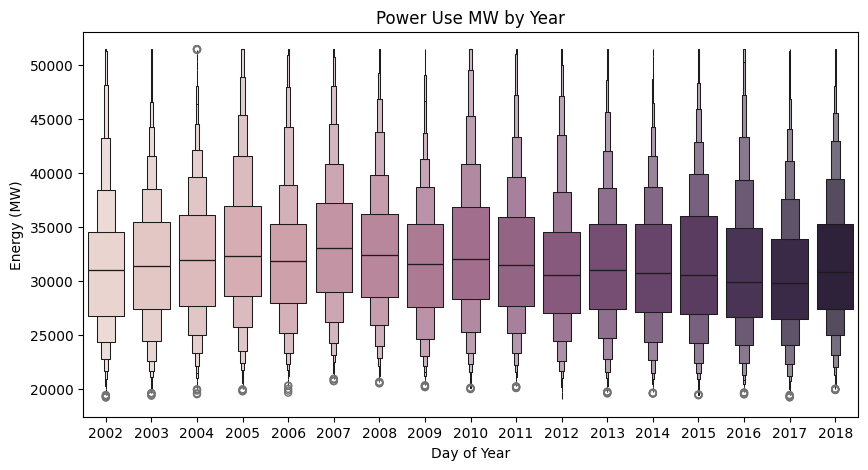

In [40]:
plot_time_range(df_features, 'year')

### Seasonality

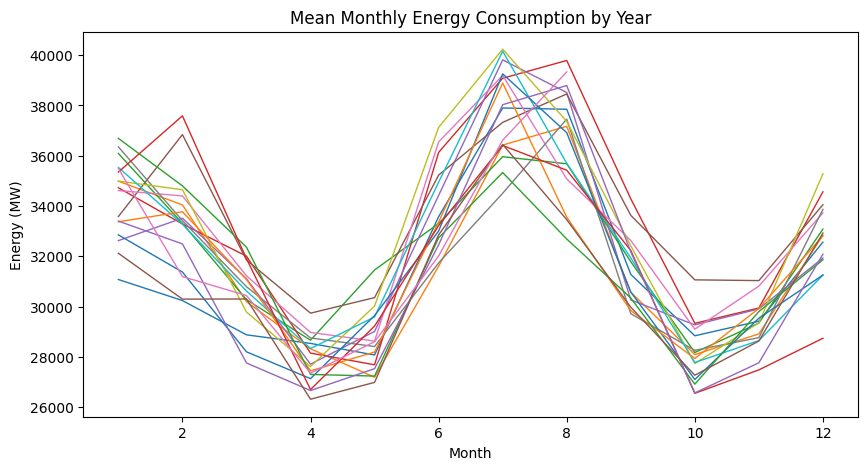

In [41]:
plot_mean_monthly(df_features)

## Plot Train/Test Split Data

In [42]:
df_train = df.loc[df.index < TARGET_CUTOFF_DATE].copy()
df_test = df.loc[df.index >= TARGET_CUTOFF_DATE].copy()

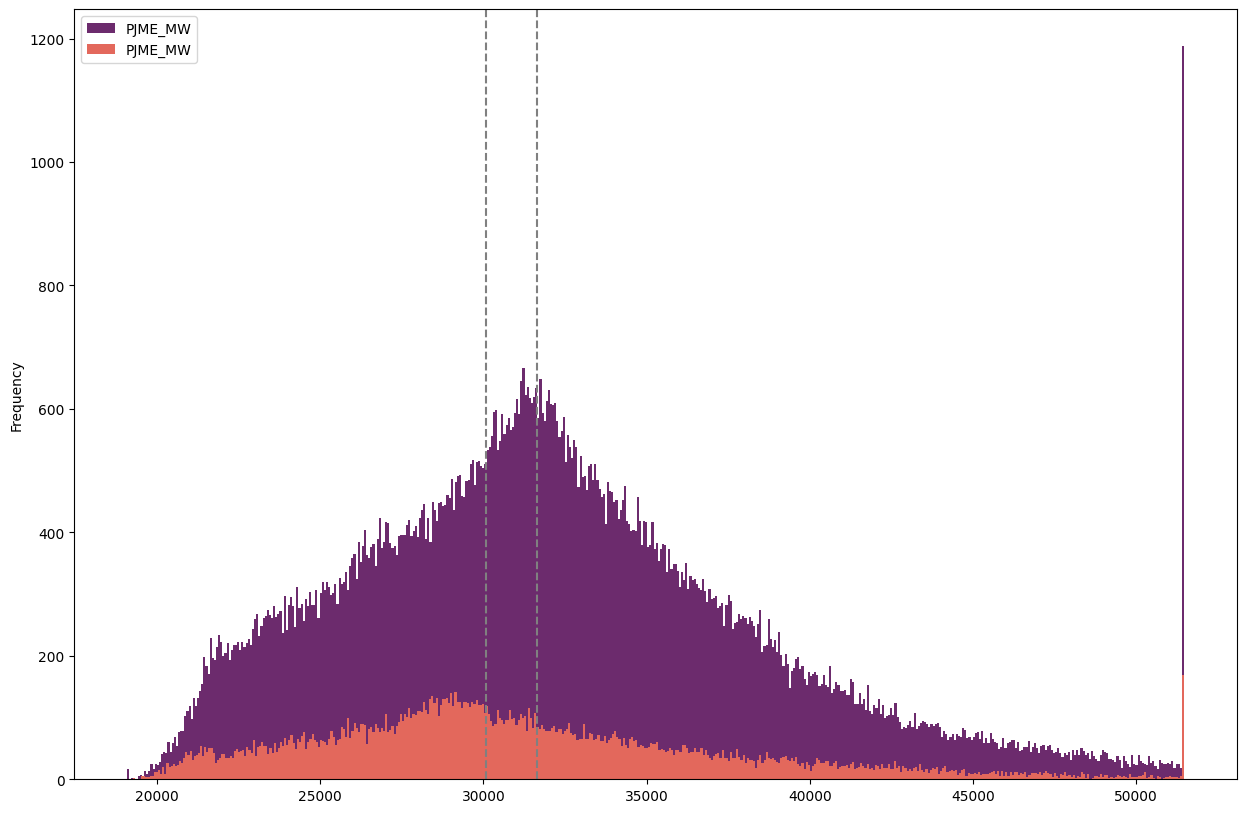

<Figure size 640x480 with 0 Axes>

In [43]:
fig, ax = plt.subplots(figsize=(15, 10))
df_train.plot(kind='hist', bins=500, color=colour_pal[5], ax=ax)
df_test.plot(kind='hist', bins=500, color=colour_pal[1], ax=ax)
plt.axvline(np.median(df_train['PJME_MW']), color='grey', ls='--')
plt.axvline(np.median(df_test['PJME_MW']), color='grey', ls='--')
plt.show()
plt.clf()

In [44]:
df_train.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [45]:
df_test.head()

,PJME_MW
Datetime,
2016-01-01 00:00:00,26686.0
2016-12-31 01:00:00,29627.0
2016-12-31 02:00:00,28744.0
2016-12-31 03:00:00,28274.0
2016-12-31 04:00:00,28162.0


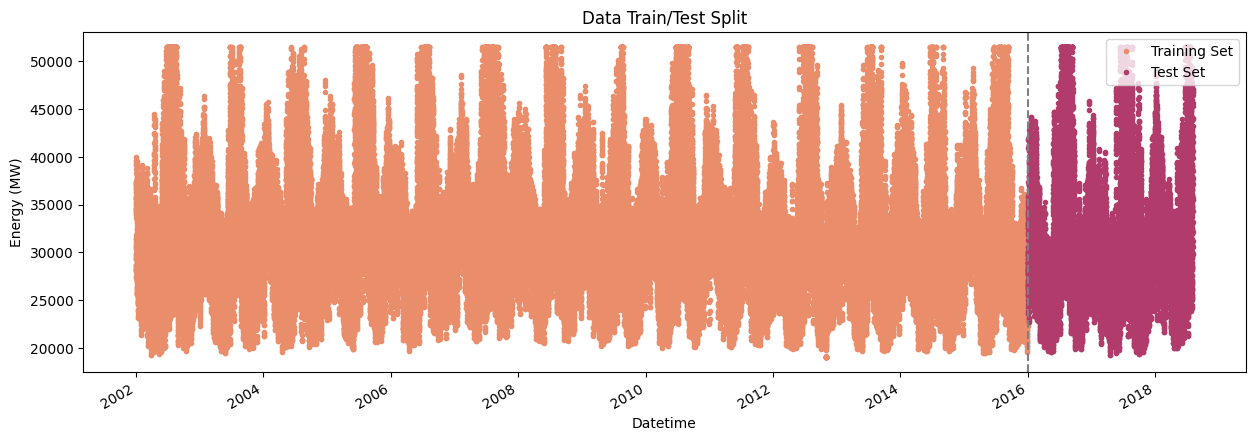

In [46]:
plot_train_test_split(df, TARGET_CUTOFF_DATE)

## Model Building

Create features for train and test data

In [47]:
train = create_timeseries_features(df_train)
test = create_timeseries_features(df_test)
train.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1


Create target and features for train and test data

In [48]:
train['weekofyear'] = train['weekofyear'].astype('int32')
test['weekofyear'] = test['weekofyear'].astype('int32')

In [49]:
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'weekofyear','quarter' ,'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [50]:
X_train.head()

,dayofyear,hour,dayofweek,weekofyear,quarter,month,year
Datetime,,,,,,,
2002-12-31 01:00:00,365,1,1,1,4,12,2002
2002-12-31 02:00:00,365,2,1,1,4,12,2002
2002-12-31 03:00:00,365,3,1,1,4,12,2002
2002-12-31 04:00:00,365,4,1,1,4,12,2002
2002-12-31 05:00:00,365,5,1,1,4,12,2002


In [51]:
y_train.head()

Datetime
2002-12-31 01:00:00    26498.0
2002-12-31 02:00:00    25147.0
2002-12-31 03:00:00    24574.0
2002-12-31 04:00:00    24393.0
2002-12-31 05:00:00    24860.0
Name: PJME_MW, dtype: float64

In [52]:
X_test.head()

,dayofyear,hour,dayofweek,weekofyear,quarter,month,year
Datetime,,,,,,,
2016-01-01 00:00:00,1,0,4,53,1,1,2016
2016-12-31 01:00:00,366,1,5,52,4,12,2016
2016-12-31 02:00:00,366,2,5,52,4,12,2016
2016-12-31 03:00:00,366,3,5,52,4,12,2016
2016-12-31 04:00:00,366,4,5,52,4,12,2016


In [53]:
y_test.head()

Datetime
2016-01-01 00:00:00    26686.0
2016-12-31 01:00:00    29627.0
2016-12-31 02:00:00    28744.0
2016-12-31 03:00:00    28274.0
2016-12-31 04:00:00    28162.0
Name: PJME_MW, dtype: float64

## Train Model

This is the first round of training, following the initial xgboost documentation and using the default parameters.

Regressor Parameters:

- base_score: 
initial prediction score for all instances, has effect on models convergence speed and accuracy (convergence speed is faster for higher values)

- booster: 
type of model to run at each iteration (default=gbtree), other options are gblinear and dart. Tree models are generally the best option because they are more flexible and can capture complex patterns in the data. (prone to overfitting)

- n_estimators: 
number of boosting rounds (can be cause of overfitting)

- early_stopping_rounds:
number of rounds without improvement after which the model will stop training (prevents overfitting)

- objective:
loss function to be minimized, i.e the function that the model will try to optimize in this case reg:linear because it is a regression problem with a linear output

- max_depth:
maximum depth of the tree, controls the complexity of the tree model (may cause overfitting if too high)

- learning_rate: 
step size shrinkage used to prevent overfitting, range is [0,1] (smaller values are better, but require more boosting rounds, higher values can cause overfitting)

- gamma:
minimum loss reduction required to make a further partition on a leaf node of the tree (higher values lead to fewer splits and more conservative models)

- reg_alpha:
L1 regularization term on weights (higher values lead to more conservative models adding more penalty to the weights), helps to reduce overfitting
- reg_lambda:
L2 regularization term on weights (higher values lead to more conservative models adding more penalty to the weights), helps to reduce overfitting

In [54]:
xgb_model = xgb.XGBRegressor(base_score=0.5, booster='gbtree', n_estimators=3000, early_stopping_rounds=50, objective="reg:linear", max_depth=6, learning_rate=0.01, min_child_weight=1, subsample=0.8, colsample_bytree=0.8, gamma=0,reg_alpha=0, reg_lambda=1, random_state=42)

xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)


[0]	validation_0-rmse:32522.90631	validation_1-rmse:31475.51607


/Users/sjo/miniforge3/envs/playground/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:26:06] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12346.86931	validation_1-rmse:11518.10197
[200]	validation_0-rmse:5357.29735	validation_1-rmse:5166.60391
[300]	validation_0-rmse:3315.16281	validation_1-rmse:3949.40043
[400]	validation_0-rmse:2823.35986	validation_1-rmse:3915.06811
[405]	validation_0-rmse:2812.34418	validation_1-rmse:3919.66164


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=3000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

## Feature Importance

Calculated as the average gain of each feature across all boosting rounds

The higher the gain, the more important the feature is in making predictions

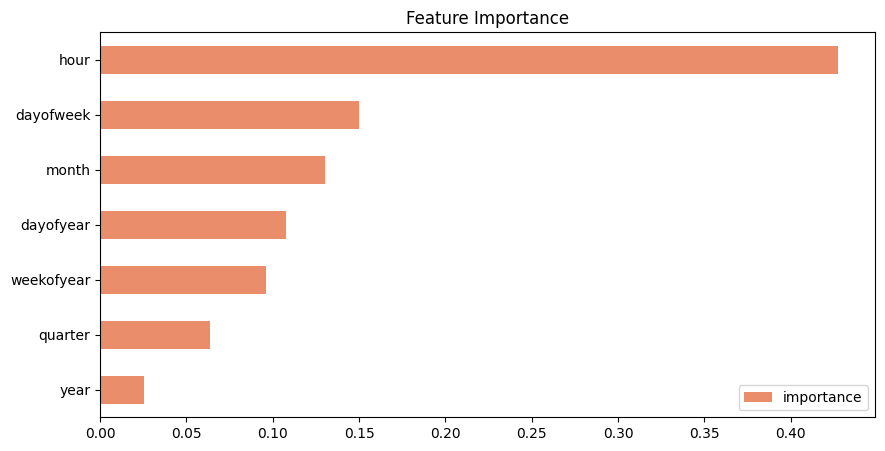

In [55]:
plot_feature_importance(xgb_model)

The model relies most on the hour feature, followed by the dayofweek and the month.

Note: All features are highly correlated with the target variable as they are all time-based features.

## Predictions Using Test Data

In [56]:
test['prediction'] = xgb_model.predict(X_test)
test.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction
Datetime,,,,,,,,,,
2016-01-01 00:00:00,26686.0,0,4,1,1,2016,1,1,53,29731.287109
2016-12-31 01:00:00,29627.0,1,5,4,12,2016,366,31,52,24994.662109
2016-12-31 02:00:00,28744.0,2,5,4,12,2016,366,31,52,23677.324219
2016-12-31 03:00:00,28274.0,3,5,4,12,2016,366,31,52,23360.767578
2016-12-31 04:00:00,28162.0,4,5,4,12,2016,366,31,52,23360.767578


### Visualizing Predictions vs Actuals

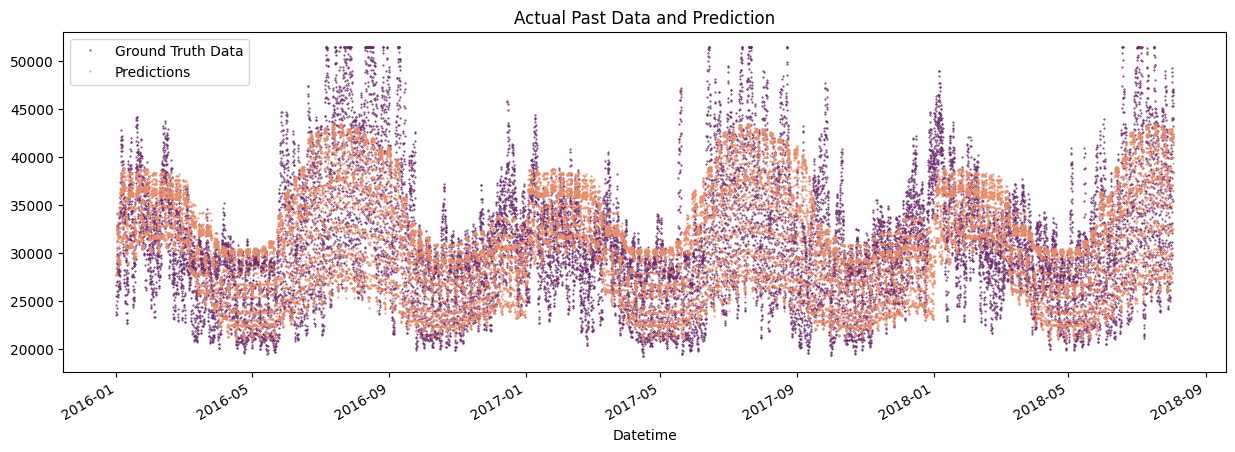

In [57]:
fig, ax = plt.subplots(figsize=(15, 5))
test['PJME_MW'].plot(ax=ax, style='.', ms=1,color=colour_pal[5])

test['prediction'].plot(ax=ax, style='.', ms=1 , color=colour_pal[0])
plt.legend(['Ground Truth Data', 'Predictions'])
ax.set_title('Actual Past Data and Prediction')
plt.show()

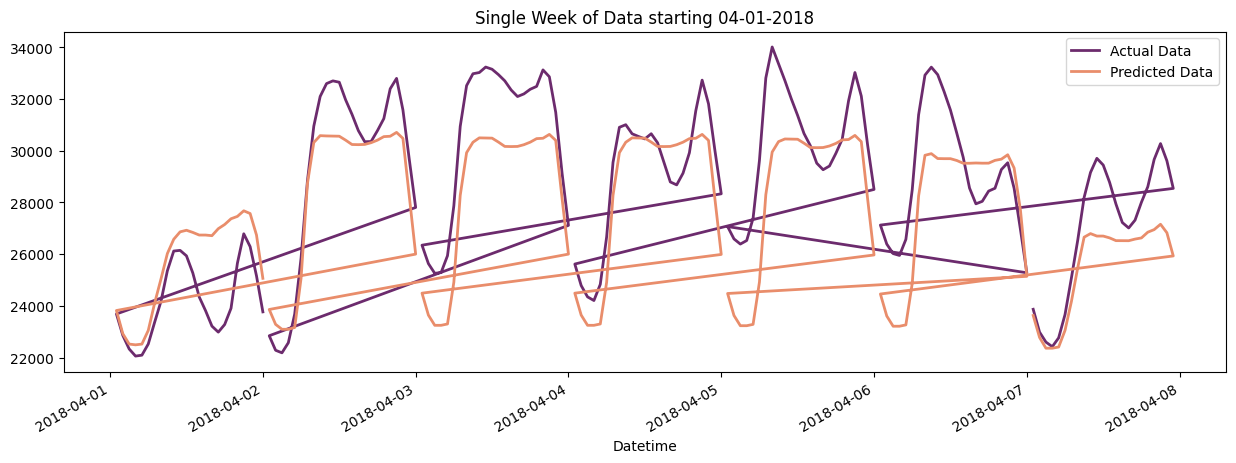

In [58]:
# select data within a specific date range
data = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]
predictions = test.loc[(test.index > '04-01-2018') & (test.index < '04-08-2018')]
# plot the actual and predicted data
ax = data['PJME_MW'].plot(figsize=(
    15, 5), title='Single Week of Data starting 04-01-2018', linewidth=2, markersize=5, color=colour_pal[5])

predictions['prediction'].plot(
    style='-', linewidth=2, markersize=2, color=colour_pal[0])

plt.legend(['Actual Data', 'Predicted Data'])
plt.show()

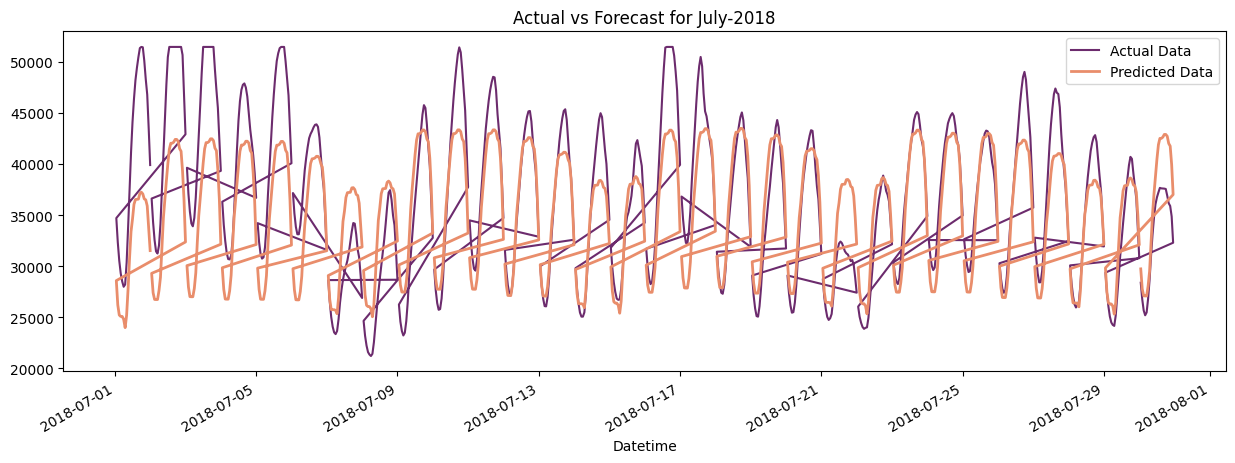

In [59]:
# select data within a specific date range
data = df.loc[(df.index > '07-01-2018') & (df.index < '07-31-2018')]
predictions = test.loc[(test.index > '07-01-2018') &
                       (test.index < '07-31-2018')]
# plot the actual portion
ax = data['PJME_MW'].plot(figsize=(
    15, 5), title='Actual vs Forecast for July-2018', style='-', markersize=5, color=colour_pal[5])

# plot the predicted portion
predictions['prediction'].plot(style='-', linewidth=2,
                        markersize=5, color=colour_pal[0])

plt.legend(['Actual Data', 'Predicted Data'])
plt.show()

## Initial RMSE

In [62]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3884.91


## Tuning Hyperparameters